<a href="https://colab.research.google.com/github/huyminh1115/Webmining-citation/blob/main/ML%20Models/Running_ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold


In [2]:
!pip install wordcloud

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Define the file path in Google Drive
test_path = '/content/drive/My Drive/data-citation/test_all.csv'
train_path = '/content/drive/My Drive/data-citation/train_all.csv'


Mounted at /content/drive


In [4]:
data_train = pd.read_csv(train_path)
data_test = pd.read_csv(test_path)

In [5]:
data_test.head()

,refer_paper_id,unique_paper_id,forward_refer,tf_idf_similarity,num_common_author,num_total_neighbors_head,num_total_neighbors_tail,gap_year,num_common_neighbors_lvl_1,num_common_neighbors_lvl_2,num_common_neighbors_lvl_3,rev_num_common_neighbors_lvl_1,rev_num_common_neighbors_lvl_2,rev_num_common_neighbors_lvl_3,mix_num_common_neighbors_lvl_1,mix_num_common_neighbors_lvl_2,mix_num_common_neighbors_lvl_3
0,1017320,1241200,0,0.000000,0,8,25,7.0,0,2,0,0,0,0,1,0,0
1,1017320,1274092,1,0.115557,0,17,25,7.0,4,10,0,0,0,0,0,0,0
2,1017382,1180315,0,0.124429,0,180,21,2.0,3,7,12,0,5,4,2,2,0
3,1017459,1120955,1,0.142920,0,77,5,10.0,0,0,0,0,32,12,0,0,0
4,10175,612977,1,0.000000,0,12,3,2.0,0,0,0,0,0,0,0,0,0


In [6]:
data_train.head()

,refer_paper_id,unique_paper_id,forward_refer,tf_idf_similarity,num_common_author,num_total_neighbors_head,num_total_neighbors_tail,gap_year,num_common_neighbors_lvl_1,num_common_neighbors_lvl_2,num_common_neighbors_lvl_3,rev_num_common_neighbors_lvl_1,rev_num_common_neighbors_lvl_2,rev_num_common_neighbors_lvl_3,mix_num_common_neighbors_lvl_1,mix_num_common_neighbors_lvl_2,mix_num_common_neighbors_lvl_3
0,98608,336288,0,0.115216,0,13,43,1.0,1,2,15,0,0,0,0,0,0
1,98608,293244,0,0.000000,0,37,43,-2.0,0,0,0,1,13,13,1,0,0
2,98608,1439659,0,0.000000,0,19,43,3.0,1,0,1,0,0,0,0,0,0
3,9861,360010,1,0.000000,0,20,8,3.0,0,0,0,0,8,3,1,2,0
4,986107,621851,1,0.000000,0,25,11,1.0,0,0,0,0,16,7,0,1,0


In [7]:
# Assuming data_train and data_test are already loaded as DataFrames
# Features and target
X_train = data_train.drop(['forward_refer'], axis=1)
y_train = data_train['forward_refer']

X_test = data_test.drop(['forward_refer'], axis=1)
y_test = data_test['forward_refer']

In [16]:

from xgboost import XGBClassifier
# Danh sách các mô hình
models = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Bernoulli Naive Bayes', BernoulliNB()),
]

# Tạo các param_grid cho từng mô hình
param_grids = {
    'Decision Tree': {'max_depth': [5, 10, 20], 'criterion': ['gini', 'entropy']},
    'Random Forest': {'n_estimators': [10, 100], 'max_depth': [5, 10, 20]},
    'Logistic Regression': {'C': [1, 10], 'solver': ['lbfgs', 'liblinear']},
    'K-Nearest Neighbors': {'n_neighbors': [5, 7], 'weights': ['uniform', 'distance']},
    'Bernoulli Naive Bayes': {'alpha': [0.001, 0.1, 1]},
}


In [18]:
# Train and evaluate each model
best_models = {}

for name, model in models:
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Training accuracy for {name}: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test accuracy for {name}: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Classification Report for {name} on test set:\n{classification_report(y_test, y_test_pred)}")

print("\nTraining complete. Best models:")
for model_name, model in best_models.items():
    print(f"{model_name}: {model}")



Training Decision Tree...
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 20}
Training accuracy for Decision Tree: 0.9660
Test accuracy for Decision Tree: 0.8153
Classification Report for Decision Tree on test set:
              precision    recall  f1-score   support

           0       0.76      0.90      0.82     46109
           1       0.89      0.74      0.80     49137

    accuracy                           0.82     95246
   macro avg       0.82      0.82      0.81     95246
weighted avg       0.83      0.82      0.81     95246


Training Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 100}
Training accuracy for Random Forest: 0.9751
Test accuracy for Random Forest: 0.8232
Classification Report for Random Forest on test set:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83     46109
           1       0.90      0.74      0.81     49137

    accuracy                  

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best parameters for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}
Training accuracy for Logistic Regression: 0.7706
Test accuracy for Logistic Regression: 0.7313
Classification Report for Logistic Regression on test set:
              precision    recall  f1-score   support

           0       0.67      0.87      0.76     46109
           1       0.83      0.61      0.70     49137

    accuracy                           0.73     95246
   macro avg       0.75      0.74      0.73     95246
weighted avg       0.75      0.73      0.73     95246


Training K-Nearest Neighbors...
Best parameters for K-Nearest Neighbors: {'n_neighbors': 7, 'weights': 'distance'}
Training accuracy for K-Nearest Neighbors: 1.0000
Test accuracy for K-Nearest Neighbors: 0.4617
Classification Report for K-Nearest Neighbors on test set:
              precision    recall  f1-score   support

           0       0.46      0.63      0.53     46109
           1       0.47      0.31      0.37     49137

    accuracy 

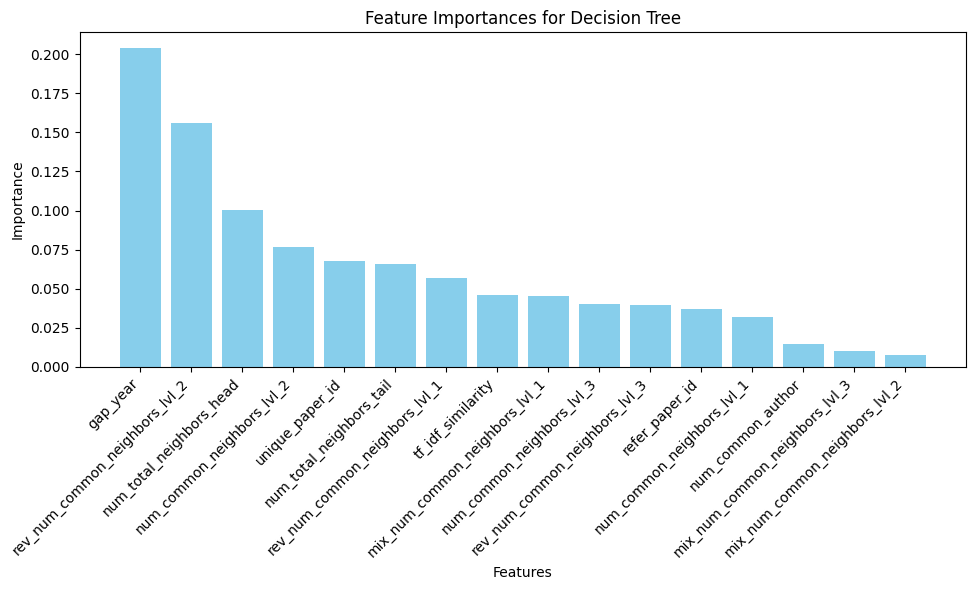

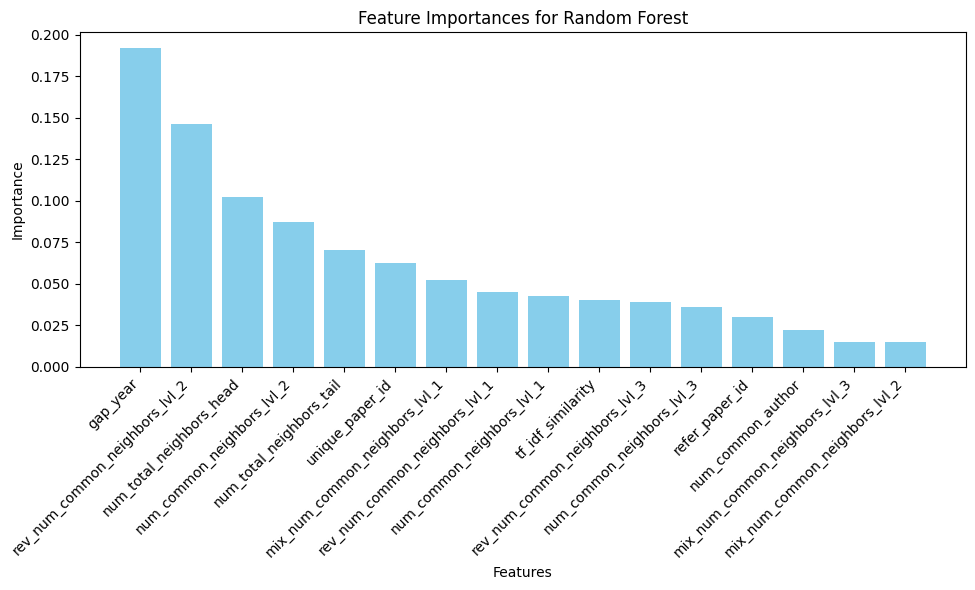


Training complete. Best models:
Decision Tree: DecisionTreeClassifier(criterion='entropy', max_depth=20)
Random Forest: RandomForestClassifier(max_depth=20)
Logistic Regression: LogisticRegression(C=10, max_iter=1000)
K-Nearest Neighbors: KNeighborsClassifier(n_neighbors=7, weights='distance')
Bernoulli Naive Bayes: BernoulliNB(alpha=0.001)


In [20]:
# Plot feature importance for Decision Tree and Random Forest
for model_name in ['Decision Tree', 'Random Forest']:
    if model_name in best_models:
        model = best_models[model_name]
        feature_importances = model.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1]
        sorted_features = X_train.columns[sorted_idx]
        sorted_importances = feature_importances[sorted_idx]

        plt.figure(figsize=(10, 6))
        plt.bar(sorted_features, sorted_importances, color='skyblue')
        plt.title(f"Feature Importances for {model_name}")
        plt.xlabel("Features")
        plt.ylabel("Importance")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

print("\nTraining complete. Best models:")
for model_name, model in best_models.items():
    print(f"{model_name}: {model}")
